In [1]:
import re
import optuna
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from data_manipulations import *

/home/tibo/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_features = pl.read_parquet('train_features.parquet')
train_targets = pl.read_parquet('train_targets.parquet')
test_features = pl.read_parquet('test_features.parquet')
test_targets = pl.read_parquet('test_targets.parquet')

data = prepare_data_for_ml(
    train_features, train_targets, test_features, test_targets,
)

In [3]:
# def restrict(frame, heads=(25, 20)):
#     keys = frame.columns[:2]
#     temp = join_many((
#         frame.select(keys[0]).unique().sort(by=keys[0]).head(heads[0]),
#         frame.select(keys[1]).unique().sort(by=keys[1]).head(heads[1]),
#     ), how='cross')
#     return frame.join(temp, on=keys)

# train_features = restrict(train_features)
# train_targets = restrict(train_targets)
# test_features = restrict(test_features)
# test_targets = restrict(test_targets)

# data = prepare_data_for_ml(train_features, train_targets, test_features, test_targets)
# data['train_features_rect'].shape, data['train_targets_rect'].shape

# Exploration

In [4]:
%%time

n_trials = 20
progress_bar = tqdm(total=n_trials)

def objective(trial):
    l1_ratio = trial.suggest_float('l1_ratio', 0.5, 1.0, log=True)  # [.1, .5, .7, .9, .95, .99, 1]
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    is_std_scaled = trial.suggest_categorical('is_std_scaled', [True, False])

    model = MultiTaskElasticNetCV(
        l1_ratio=l1_ratio,  # 0.5
        fit_intercept=fit_intercept,  # True
        n_alphas=50,  # 100
        cv=5,
        random_state=0,
        max_iter=2000,  # 1000
    )
    if is_std_scaled:
        model = make_pipeline(StandardScaler(), model)

    score = cross_val_score(
        model,
        data['train_features_rect'].to_numpy(),
        data['train_targets_rect'].to_numpy(),
        cv=5,
        scoring=scoring,
        n_jobs=-1,
    )

    progress_bar.update(1)
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

100%|██████████| 20/20 [27:55<00:00, 83.02s/it][I 2025-04-20 13:21:51,657] Trial 19 finished with value: 0.7418563770060069 and parameters: {'l1_ratio': 0.9467119903809577, 'fit_intercept': False, 'is_std_scaled': True}. Best is trial 3 with value: 0.7418576413044501.


CPU times: user 1.7 s, sys: 978 ms, total: 2.68 s
Wall time: 27min 55s


In [5]:
prefix = r'^params_'
cv_results = pl.DataFrame(study.trials_dataframe())
cv_results = (
    cv_results
    .rename({
        col: re.sub(prefix, '', col)
        for col in cv_results.columns
    })
)

{'fit_intercept': False, 'is_std_scaled': False}


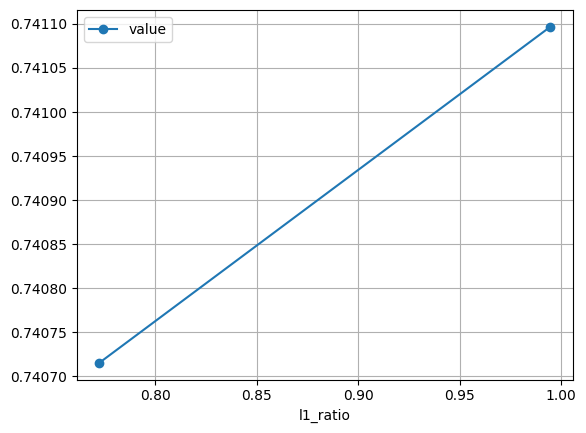

{'fit_intercept': True, 'is_std_scaled': True}


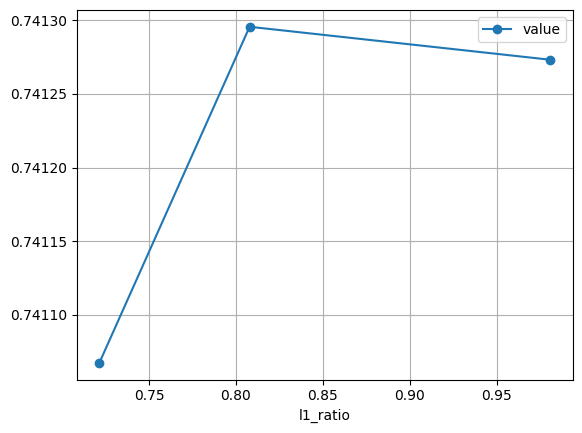

{'fit_intercept': False, 'is_std_scaled': True}


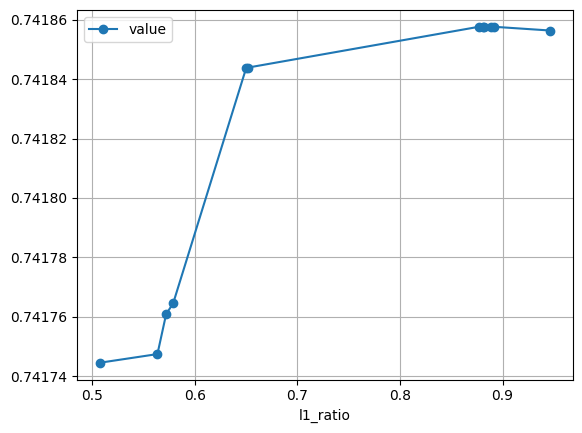

{'fit_intercept': True, 'is_std_scaled': False}


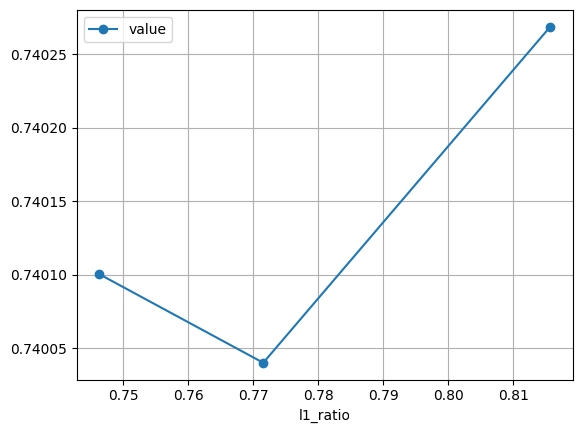

In [6]:
discrete = ['fit_intercept' ,'is_std_scaled']
continuous = ['l1_ratio']
parts = cv_results.partition_by(discrete, as_dict=True)
for key, part in parts.items():
    print(dict(zip(discrete, key)))
    plot_ts(part.select(*continuous, 'value').sort('l1_ratio'), marker='o')
    plt.show()

In [7]:
best = cv_results.filter(pl.col('value') == pl.col('value').max()).select(discrete + continuous).to_dicts()[0]
best

{'fit_intercept': False, 'is_std_scaled': True, 'l1_ratio': 0.8769765455966552}

In [8]:
# assert False

# Stability

In [9]:
param_grid = {
    'multitaskelasticnetcv__l1_ratio': np.linspace(0.75, 1.0, 10),
}
model = MultiTaskElasticNetCV(
    l1_ratio=0.5,
    fit_intercept=False,
    n_alphas=50,  # 100
    cv=5,
    random_state=0,
    max_iter=2000,  # 1000
)
model = make_pipeline(StandardScaler(), model)

In [10]:
%%time
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=3,
)
_ = grid.fit(
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 7min 13s, sys: 1.37 s, total: 7min 14s
Wall time: 16min 22s


In [11]:
cv_results = grid.cv_results_
cv_results = pl.concat([
    pl.DataFrame({k: v for k, v in cv_results.items() if k != 'params'}),
    # pl.DataFrame(cv_results['params']),
], how='horizontal')

prefix = r'^param_'
cv_results = (
    cv_results
    .rename({
        col: re.sub(prefix, '', col)
        for col in cv_results.columns
    })
)

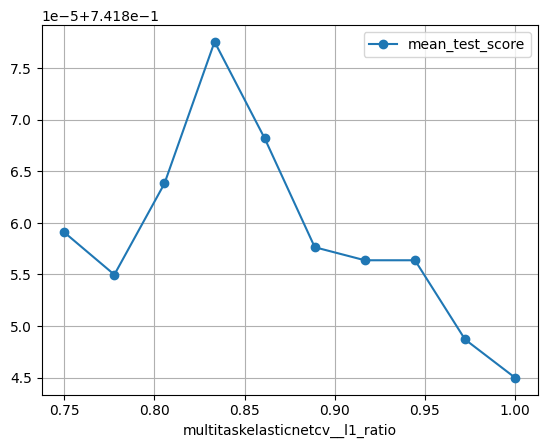

In [12]:
continuous = ['multitaskelasticnetcv__l1_ratio']
plot_ts(cv_results.select(*continuous, 'mean_test_score').sort('multitaskelasticnetcv__l1_ratio'), marker='o')
plt.show()

In [13]:
cv_results.filter(pl.col('mean_test_score') == pl.col('mean_test_score').max()).select(continuous).to_dicts()[0]

{'multitaskelasticnetcv__l1_ratio': 0.8333333333333334}

In [14]:
# assert False

# Learning curve

In [15]:
model = MultiTaskElasticNetCV(
    l1_ratio=0.83,  # 0.5
    fit_intercept=False,  # True
    n_alphas=100,  # 100
    cv=5,
    random_state=0,
    max_iter=2000,  # 1000
)
model = make_pipeline(StandardScaler(), model)

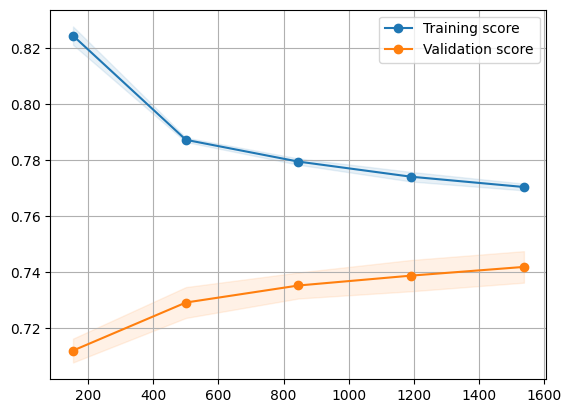

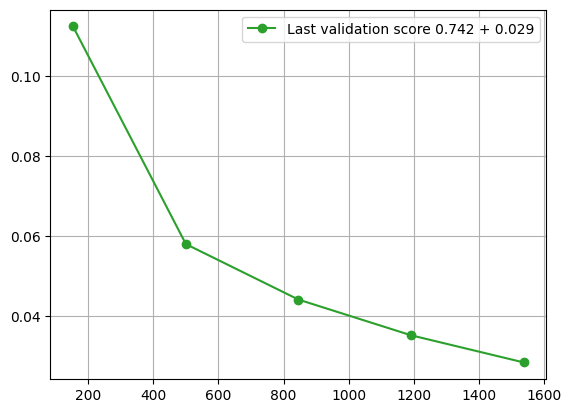

CPU times: user 468 ms, sys: 156 ms, total: 624 ms
Wall time: 5min 5s


In [16]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    model,
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# Score on test

In [17]:
fitted_model, preds = fit_predict_sklearn_model(
    train_features, train_targets, test_features, test_targets,
    model,
)
join_truth_and_score(preds, data['test_days'], test_targets)

0.7350942392282623

[CV 2/5] END multitaskelasticnetcv__l1_ratio=0.7777777777777778;, score=0.739 total time= 4.7min
[CV 3/5] END multitaskelasticnetcv__l1_ratio=0.8611111111111112;, score=0.751 total time= 4.8min
[CV 2/5] END multitaskelasticnetcv__l1_ratio=0.9444444444444444;, score=0.739 total time= 4.9min
[CV 3/5] END multitaskelasticnetcv__l1_ratio=0.7777777777777778;, score=0.751 total time= 5.6min
[CV 4/5] END multitaskelasticnetcv__l1_ratio=0.8888888888888888;, score=0.736 total time= 4.7min
[CV 2/5] END multitaskelasticnetcv__l1_ratio=0.9722222222222222;, score=0.739 total time= 3.7min
[CV 5/5] END multitaskelasticnetcv__l1_ratio=0.8055555555555556;, score=0.740 total time= 4.1min
[CV 2/5] END multitaskelasticnetcv__l1_ratio=0.8333333333333334;, score=0.739 total time= 4.4min
[CV 4/5] END multitaskelasticnetcv__l1_ratio=0.9166666666666666;, score=0.736 total time= 4.8min
[CV 5/5] END multitaskelasticnetcv__l1_ratio=1.0;, score=0.741 total time= 1.7min
[CV 1/5] END multitaskelasticnetcv__l1_ratio=